<a href="https://colab.research.google.com/github/RUPA-VARSHINI-B/codsoft_task3/blob/main/Movie.Genre_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing The Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
train_data=pd.read_csv('./train_data.txt',sep=':::',engine='python',names=['Title','Genre','Description'])
train_data.head()

,Title,Genre,Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [ ]:
test_data=pd.read_csv('./test_data.txt',sep=':::',engine='python',names=['ID', 'Title','Description'])
test_data.head()

,ID,Title,Description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...


In [ ]:

train_data.describe()

,Title,Genre,Description
count,44891,44890,44890
unique,44891,27,44797
top,Oscar et la dame rose (2009),drama,Grammy - music award of the American academy ...
freq,1,11263,10


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44891 entries, 1 to 44891
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        44891 non-null  object
 1   Genre        44890 non-null  object
 2   Description  44890 non-null  object
dtypes: object(3)
memory usage: 1.4+ MB


In [ ]:
train_data.isnull().sum()

Title          0
Genre          1
Description    1
dtype: int64

Text(0, 0.5, 'Count Of Genres')

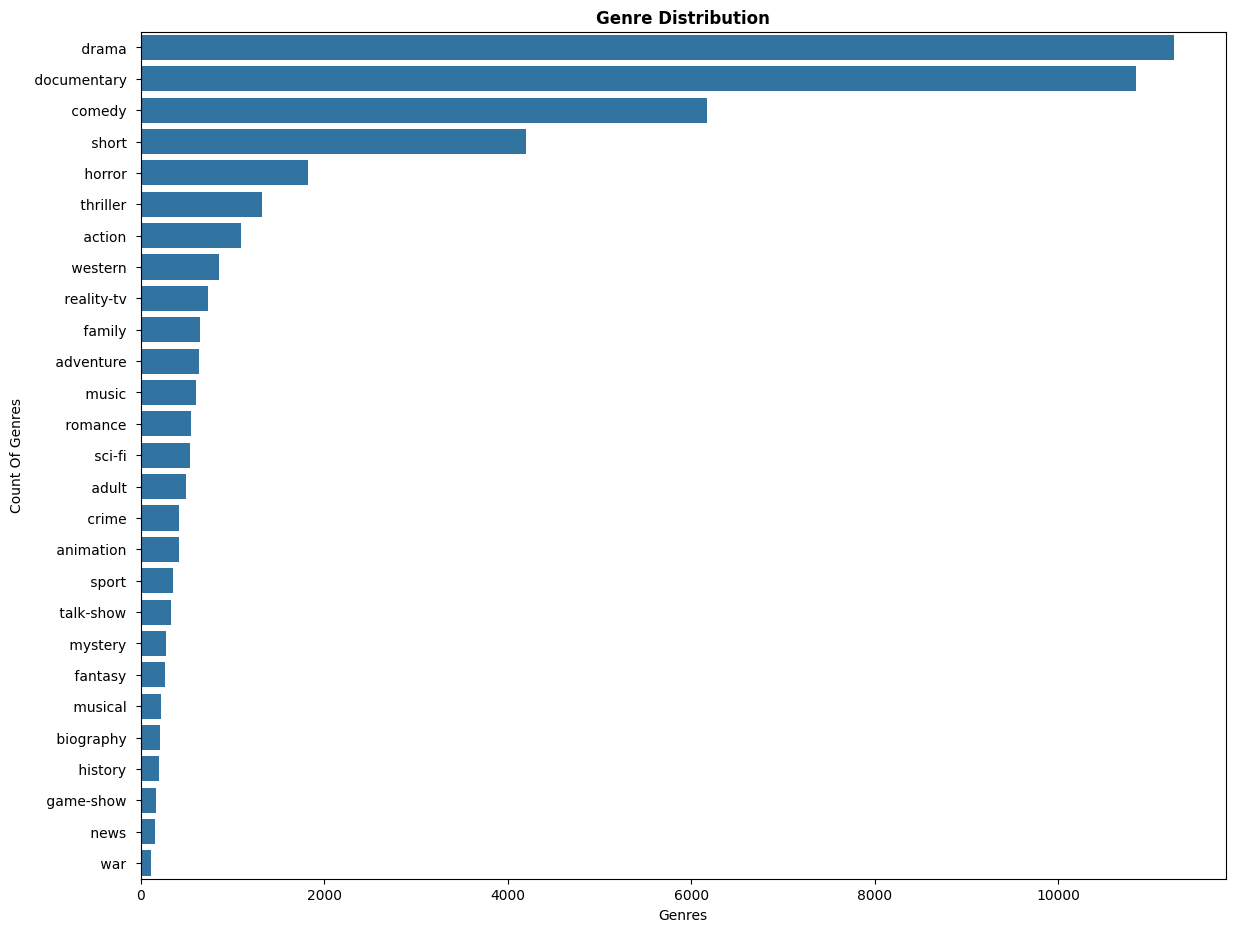

In [ ]:
plt.figure(figsize=(14,11))
count_of_genres=train_data.Genre.value_counts()
sns.barplot(x=count_of_genres,y=count_of_genres.index,orient='h')
plt.title('Genre Distribution',fontweight='bold')
plt.xlabel('Genres')
plt.ylabel('Count Of Genres')

In [ ]:
import pandas as pd

train_data['length'] = train_data['Description'].apply(lambda x: len(x) if pd.notna(x) else 0)
train_data.head()


,Title,Genre,Description,length
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625


Data Cleaning and Preprocessing



In [ ]:
stemmer = LancasterStemmer()
stop_words = set(stopwords.words('english'))

def text_cleaning(text):
    if text and pd.notna(text):  # Check if the value is not None
        text = text.lower()
        text = re.sub('-', ' ', text.lower())
        text = re.sub(f'[{string.digits}]', ' ', text)
        text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words])
        text = re.sub(r'@\S+', '', text)
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'pic.\S+', '', text)
        text = re.sub(r"[^a-zA-Z+']", ' ', text)
        text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')
        text = "".join([i for i in text if i not in string.punctuation])
        words = nltk.tokenize.word_tokenize(text, language="english", preserve_line=True)
        stopwords = nltk.corpus.stopwords.words('english')
        text = " ".join([i for i in words if i not in stopwords and len(i) > 2])
        text = re.sub("\s[\s]+", " ", text).strip()
        return re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    else:
        return ""

# test the function
dummy_input = "Hello @ijkl I see-you have 999988757575850--@@##"
print(f'Original Input: {dummy_input}')
print(f'After Cleaning: {text_cleaning(dummy_input)}')

# Apply the function to the DataFrame
train_data['Text_cleaning'] = train_data['Description'].apply(text_cleaning)
test_data['Text_cleaning'] = test_data['Description'].apply(text_cleaning)
train_data.head()


Original Input: Hello @ijkl I see-you have 999988757575850--@@##
After Cleaning: hello see


,Title,Genre,Description,length,Text_cleaning
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546,list convers doct parents year old osc learn n...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184,broth sist past incestu rel cur murd relations...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650,bus empty stud field trip muse nat history lit...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082,help unemploy fath mak end meet edi twin sist ...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625,films titl ref recov body ground zero also sta...


In [ ]:
train_data['Length_Text_Cleaning']=train_data['Text_cleaning'].apply(len)
train_data.head()


,Title,Genre,Description,length,Text_cleaning,Length_Text_Cleaning
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546,list convers doct parents year old osc learn n...,324
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184,broth sist past incestu rel cur murd relations...,83
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650,bus empty stud field trip muse nat history lit...,325
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082,help unemploy fath mak end meet edi twin sist ...,616
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625,films titl ref recov body ground zero also sta...,282


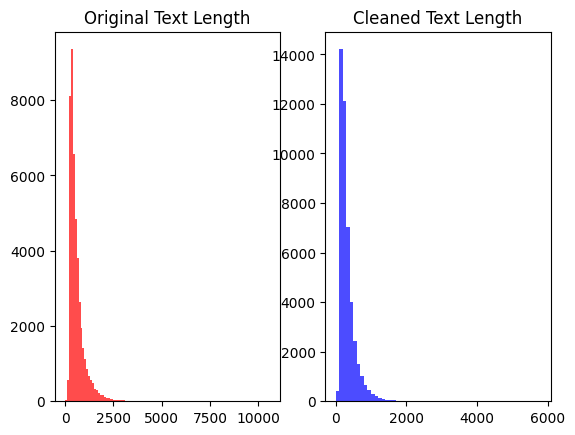

In [ ]:
train_data['Description_length'] = train_data['Description'].apply(lambda x:
len(x) if x is not None else 0)

# Original
plt.subplot(1, 2, 1)
original_lengths = train_data['Description_length']
plt.hist(original_lengths, bins=range(0, max(original_lengths) + 100, 100),
         color='red', alpha=0.7)
plt.title('Original Text Length')

# After cleaning
plt.subplot(1, 2, 2)
cleaned_lengths = train_data['Text_cleaning'].apply(len)
plt.hist(cleaned_lengths, bins=range(0, max(cleaned_lengths) + 100, 100),
         color='blue', alpha=0.7)
plt.title('Cleaned Text Length')

plt.show()


In [ ]:
(train_data['Length_Text_Cleaning']>2000).value_counts()

False    44822
True        69
Name: Length_Text_Cleaning, dtype: int64

In [ ]:
print('Dataframe size (before removal): ',len(train_data))
filt=train_data['Length_Text_Cleaning']>2000
train_data.drop(train_data[filt].index,axis=0,inplace=True)
print('Dataframe size (after removal): ',len(train_data))
print(f'Removed rows: {filt.sum()}')

Dataframe size (before removal):  44891
Dataframe size (after removal):  44822
Removed rows: 69


In [ ]:
num_words = 50000
max_len = 250
tokenizer = Tokenizer(num_words=num_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train_data['Text_cleaning'].values)


In [ ]:
test_data.head()

,ID,Title,Description,Text_cleaning
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar...",bran lov lif car apartment job espec girlfrien...
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch...",spain march quico naughty child three belong w...
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...,year lif albin famy shepherd transylvania dire...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi...",fath died spok broth year sery cancer diego ta...
4,5,Er nu zhai (1955),Before he was known internationally as a mart...,known intern mart art superstar bruc lee appea...


In [ ]:
test_data_solution=pd.read_csv('./test_data_solution.txt',sep=':::',engine='python',names=['ID', 'Title','Genre','Description'])
test_data_solution.head()

,ID,Title,Genre,Description
0,1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),drama,Before he was known internationally as a mart...


Text Vectorization (TF-IDF)

In [ ]:
X = tokenizer.texts_to_sequences(train_data['Text_cleaning'].values)
X = pad_sequences(X, maxlen=max_len)
y = pd.get_dummies(train_data['Genre']).values

X_test = tokenizer.texts_to_sequences(test_data['Text_cleaning'].values)
X_test = pad_sequences(X_test, maxlen=max_len)
y_test = pd.get_dummies(test_data_solution['Genre']).values

In [ ]:
#LSTM
EMBEDDING_DIM = 100
model = Sequential()
model.add(Embedding(num_words, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.1, recurrent_dropout=0.2))
model.add(Dense(27, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Training the model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Assuming X and y are your complete dataset
# Splitting the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Assuming model is defined and compiled before this point

# Assuming X_train and y_train are your training data
callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=2, mode='auto')]

# Training the model
history = model.fit(X_train, y_train, epochs=4, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks)


Epoch 1/4
1121/1121 [==============================] - 716s 638ms/step - loss: 0.8109 - accuracy: 0.7636 - val_loss: 0.7956 - val_accuracy: 0.7708
Epoch 2/4
1121/1121 [==============================] - 702s 626ms/step - loss: 0.5636 - accuracy: 0.8366 - val_loss: 0.8911 - val_accuracy: 0.7458
Epoch 3/4
1121/1121 [==============================] - 702s 626ms/step - loss: 0.3791 - accuracy: 0.8889 - val_loss: 0.9857 - val_accuracy: 0.7297


Plotting Accuracy and Loss

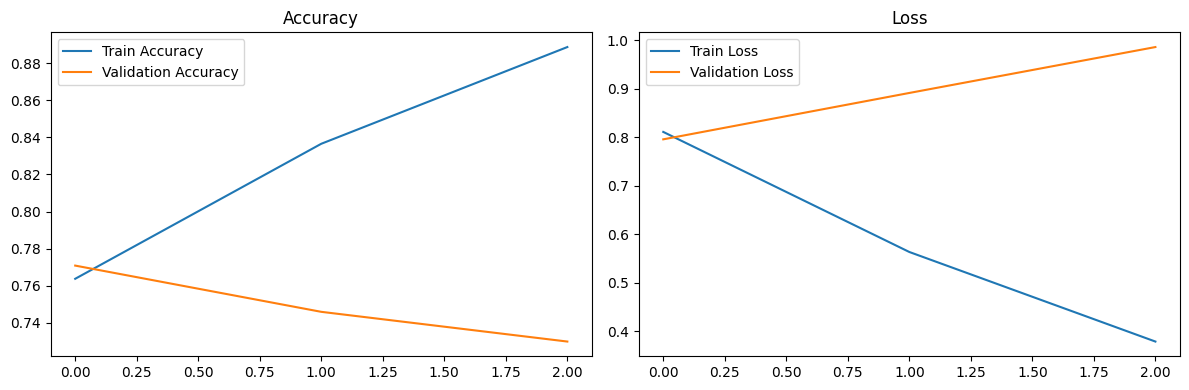

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.tight_layout()
plt.show()


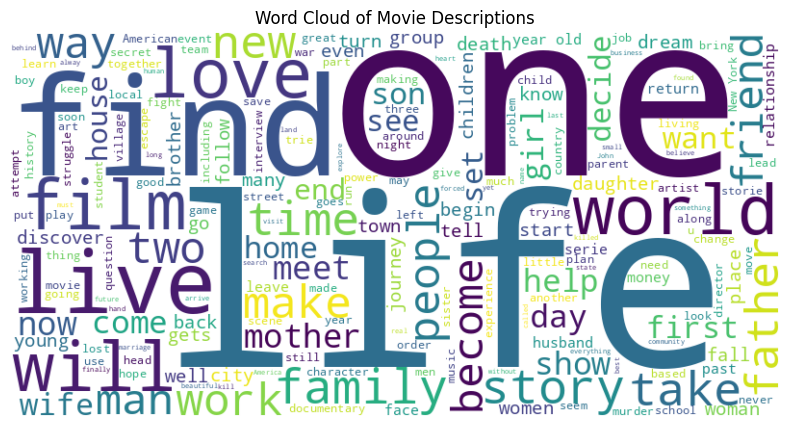

In [4]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming you have loaded your dataset into a DataFrame named 'train_data'
train_data = pd.read_csv('./train_data.txt', sep=':::', engine='python', names=['Title', 'Genre', 'Description'])
train_data.head()

# Generate a word cloud based on the 'Description' column
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(train_data['Description']))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Movie Descriptions')
plt.show()


<ipython-input-5-f5273f13ce65>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Genre', data=train_data, palette='viridis')


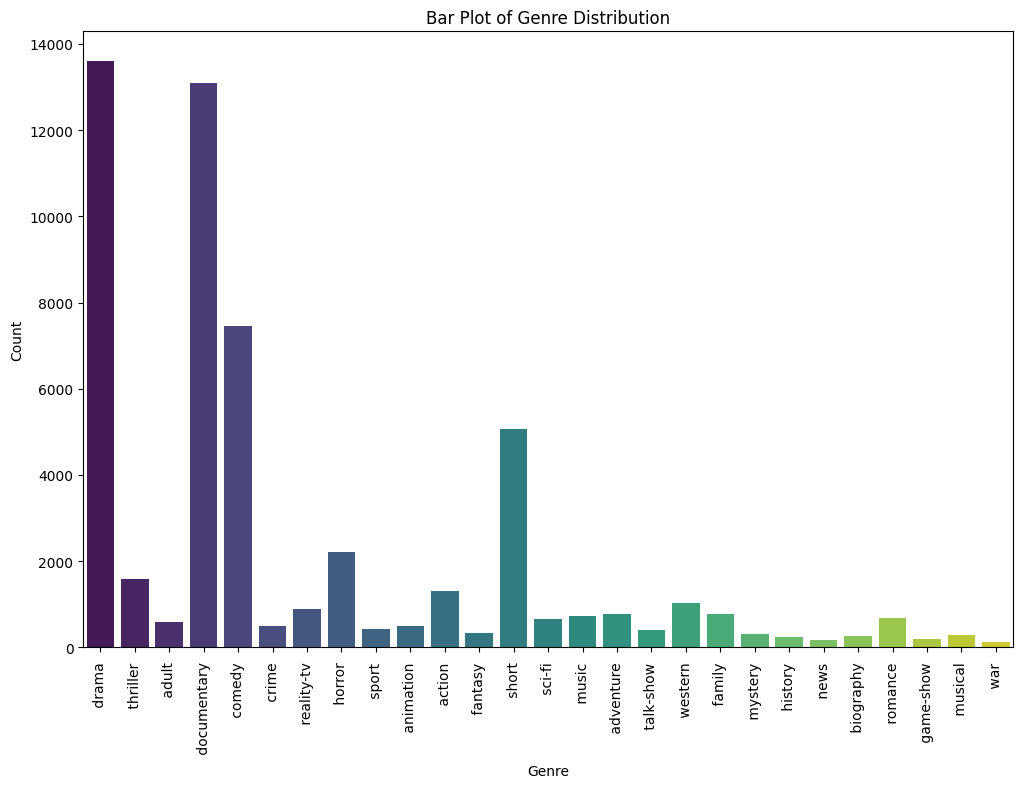

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have loaded your dataset into a DataFrame named 'train_data'
train_data = pd.read_csv('./train_data.txt', sep=':::', engine='python', names=['Title', 'Genre', 'Description'])
train_data.head()

# Plotting a bar chart for genre distribution
plt.figure(figsize=(12, 8))
sns.countplot(x='Genre', data=train_data, palette='viridis')
plt.title('Bar Plot of Genre Distribution')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()
